# Chapter 4. Tides, Rotation and Shape #

## Action by Sofía Arboleda-Bolívar ##

This notebook is made with the intention of giving some theoretical and practical tools for the fourth chapter of Murray & Dermott Astrodynamics book.

In [3]:
!pip3 install --upgrade -q pip
!pip3 install -q pymcel
!pip3 install -q celluloid
!pip3 install -q spiceypy
!pip3 install -q astroquery 
!pip3 install -q geopandas
!pip -q install plotly
!pip -q install sympy
!pip -q install scipy

In [4]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import astropy 
from astropy import constants as const
from astropy import units as u
import spiceypy as spy
from astroquery.jplhorizons import Horizons
import datetime
from astropy.time import Time
import geopandas as gpd
import pandas as pd
import plotly.graph_objs as go
from scipy.special import sph_harm
from mpl_toolkits.mplot3d import Axes3D


### 4.1 Tidal Bulge 


Derivation of potentials from interaction between a planet and a satellite

Given the potential on a point P on the surface of a planet due to a satellite:

$V = -G \frac{m_s}{\triangle}$

<img src="Figures&plots/img_3.png" />

With $\triangle = a\left[ 1 - 2\left(\frac{R_p}{a}\right)cos(\Psi) + \left(\frac{R_p}{a}\right)^2\right]^{1/2}$

And since $R_p/a << 1$, $\triangle$ can be expaned binomially. However, we can consider the polynomial expansion in taylor series using sympy:

In [5]:
#Define x as the Rp/a ratio to expand around it
x, psi = sym.symbols('x, Psi') 

# Define the expression (here we use a negative exponential 
    #due to the position of the polynomial in the potential formula).

expr = (1-2*x*sym.cos(psi)+ x**2 )**(-1/2)

#Perform of Taylor series expansion
taylor_series = sym.series(expr, x, n=3)

display(Markdown('The corresponding expansion is'))
display(taylor_series)


The corresponding expansion is

1 + 1.0*x*cos(Psi) + x**2*(1.5*cos(Psi)**2 - 0.5) + O(x**3)

Now you can see that the potential is given by:
$V=-\mathcal{G} \frac{m_{\mathrm{s}}}{a}\left[1+\left(\frac{R_{\mathrm{p}}}{a}\right) \cos \psi+\left(\frac{R_{\mathrm{p}}}{a}\right)^2 \frac{1}{2}\left(3 \cos ^2 \psi-1\right)+\cdots\right]$

Since the potential can be divided in those first three terms as $V_1, V_2, V_3$, we can look at the contribution of each one of them in the total potential. For that, let's use Earth-Moon system data:


In [6]:
#Constants
R_earth = float(const.R_earth.value) #Earth's radius
G = float(const.G.value)
g = float(const.g0.value)
au = float(const.au.value)

m_earth = float(const.M_earth.value)
m_moon = 7.342e22 # Moon mass
a_em = 384400e3 # Mean Earth-Moon distance
m_sun = float(const.M_sun.value)


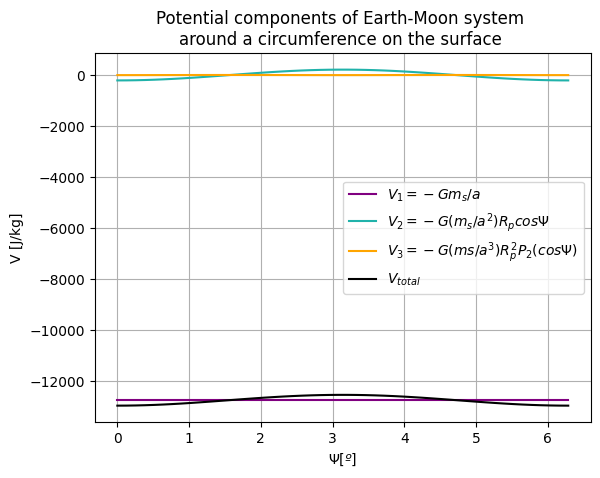

/var/folders/0s/_xxgbjs554192y_2w2mspv3c0000gn/T/ipykernel_13759/724500987.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


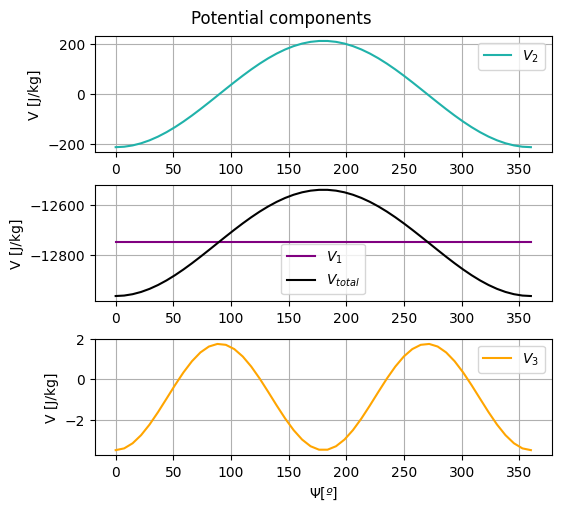

In [7]:
x_s = np.linspace(0, 2*np.pi)

#Legendre polynomial of degree 2 in cos(Psi)
P_2 = lambda psi: (1/2)*(3*np.cos(psi)**2 - 1)

#Potential components
V1 = np.array([-G*(m_moon/a_em) for i in range(len(x_s))]) #Array with constant value
V2 = lambda psi: V1*(R_earth/a_em)*np.cos(psi)
V3 = lambda psi: V1*(R_earth/a_em)**2*P_2(psi)

#Triangle function 
serie_truncada = taylor_series.removeO() #Remove the higher order factor from the taylor series
V = sym.lambdify((psi, x), serie_truncada,'numpy') #Lambdification of function in terms of psi and x

# Total potential
V_tot = V1[0]*V(x_s, R_earth/a_em)

plt.plot(x_s, V1, c='purple', label='$V_{1} = -Gm_s/a$')
plt.plot(x_s, V2(x_s), c='lightseagreen', label='$V_{2} = -G(m_s/a^2)R_p cos\Psi $')
plt.plot(x_s, V3(x_s), c='orange', label='$V_{3} = -G (ms/a^3) R_p^2 P_2(cos\Psi)$')
plt.plot(x_s, V_tot, c='black', label='$V_{total}$' )
plt.title('Potential components of Earth-Moon system \naround a circumference on the surface ')
plt.xlabel('$\Psi [º]$')
plt.ylabel('V [J/kg]')
plt.legend()
plt.grid()
plt.show()

fig, axs = plt.subplots(3, figsize=(5.5, 5),
                        layout="constrained")
fig.suptitle('Potential components')
axs[2].set_xlabel('$\Psi [º]$')
axs[0].set_ylabel('V [J/kg]')
axs[1].set_ylabel('V [J/kg]')
axs[2].set_ylabel('V [J/kg]')
axs[0].plot(np.degrees(x_s), V2(x_s), c='lightseagreen', label='$V_2$')
axs[2].plot(np.degrees(x_s), V3(x_s), c='orange', label='$V_{3} $')
axs[1].plot(np.degrees(x_s), V1, c='purple', label='$V_{1} $')
axs[1].plot(np.degrees(x_s), V_tot, c='black', label='$V_{total}$')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()

fig.show()



We can prove the relation between $\Psi$ angle and the colatitude and longitude of a point on Earth's surface and a satellite, as shown in figure 4.4 of Murray Dermott's:

<img src="Figures&plots/img_1.png" />

 It can be proved that:

$$\cos \psi=\cos \theta_{\mathrm{P}} \cos \theta_{\mathrm{M}}+\sin \theta_{\mathrm{P}} \sin \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right)$$ **Proof using cosine rule:**



$\begin{aligned} & a^2=p^2+m^2-2 p m \cos \psi \\ & \cos \psi=\frac{a^2-p^2-m^2}{-2 p m} \\ & a^2=\left(x_p-x_m\right)^2+\left(y_p-y_m\right)^2+\left(z_p-z_m\right)^2 \\ & p^2=x p^2+y p^2+z p^2 \\ & m^2=x_m^2+y_m^2+z_m^2 \\ \end{aligned}$

$$cos\Psi = \frac{(x_p-x_m)^2+(y_p-y_m)^2+(z_p-z_m)^2-(x_p^2+y_p^2+z_p^2)^2-(x_m^2+y_m^2+z_m^2)^2}{-2pm}$$
$$cos\Psi = \frac{-2x_p x_m -2y_p y_m -2z_p z_m}{-2pm}$$
$$cos\Psi = \frac{x_p x_m +y_p y_m +z_p z_m}{pm}$$

And since the spherical coordinates of P and M are:

$P = (x_p, y_p, z_p) = (p sen\theta_p cos\Phi_p, p sen\theta_p sen\Phi_p, p cos\theta_p)$

$M = (x_m, y_m, z_m) = (m sen\theta_m cos\Phi_m, m sen\theta_m sen\Phi_m, m cos\theta_m)$

We have:
$$cos\Psi = \frac{(p sen\theta_p cos\Phi_p) (m sen\theta_m cos\Phi_m) + (p sen\theta_p sen\Phi_p) (m sen\theta_m sen\Phi_m) + (p cos\theta_p) (m cos\theta_m)}{pm}$$

$$cos\Psi = cos\theta_p cos\theta_m + sen\theta_p sen\theta_m(cos\Phi_p cos\Phi_m + sen\Phi_p sen\Phi_m)$$

Finally:

$$cos\Psi = cos\theta_p cos\theta_m + sen\theta_p sen\theta_m(cos(\Phi_p-\Phi_m))$$




Hence: $$\begin{aligned} \frac{1}{2}\left(3 \cos ^2 \psi-1\right)= & \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{P}}-1\right) \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{M}}-1\right) \\ & +\frac{3}{4} \sin ^2 \theta_{\mathrm{P}} \sin ^2 \theta_{\mathrm{M}} \cos 2\left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) \\  & +\frac{3}{4} \sin 2 \theta_{\mathrm{P}} \sin 2 \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) .\end{aligned}$$

Let's use a routine to obtain these coordinates from any given point on Earth and and another body. 
For that we're going to need to NAIF kernels imported bellow:

In [8]:
!wget -O earth_200101_990628_predict.bpc https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_200101_990628_predict.bpc

--2023-03-23 10:54:42--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_200101_990628_predict.bpc
Resolviendo naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Conectando con naif.jpl.nasa.gov (naif.jpl.nasa.gov)[137.78.232.95]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 15121408 (14M)
Grabando a: «earth_200101_990628_predict.bpc»

earth_200101_990628 100%[===================>]  14.42M  10.0MB/s    en 1.4s    

2023-03-23 10:54:44 (10.0 MB/s) - «earth_200101_990628_predict.bpc» guardado [15121408/15121408]



In [9]:
!wget -O latest_leapseconds.tls https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls

--2023-03-23 10:54:44--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls
Resolviendo naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Conectando con naif.jpl.nasa.gov (naif.jpl.nasa.gov)[137.78.232.95]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 5257 (5.1K) [text/plain]
Grabando a: «latest_leapseconds.tls»

latest_leapseconds. 100%[===================>]   5.13K  --.-KB/s    en 0s      

2023-03-23 10:54:44 (12.2 MB/s) - «latest_leapseconds.tls» guardado [5257/5257]



In [10]:
spy.furnsh(["earth_200101_990628_predict.bpc","latest_leapseconds.tls"])  
    

To use the coordinates from NAIF kernels we must fix a unique reference frame for both objects. It means that we need to convert from Earth fixed rerefence frame to J2000 reference frame:
<img src="Figures&plots/EFCoord.png" width="200" /> to <img src="Figures&plots/J2000RF.png" width="300"/>

Figures from: https://dirsig.cis.rit.edu/

Now we can implement the following routine:

In [11]:
def Coordinate_transf(P, S, t):
    """
    This routine is a facility to transform Earth coordinates
    of a given point at a given time to J2000 coordinates.
    
    Input: P = array[lon[º], lat[º], alt[km]], S = array['satellite_name',
    Horizons_id], t = string("yyyy-mm-dd hh:mm:ss")
    
    Output: np.array([phiP, thetaP, phiS, thetaS])
    
    It receives the coordinates of a point P, the indicator of the satellite
    (or celestial body to be used) as a list with a string and a Horizons 
    number indicator and the given date (in date time format) in which the 
    data is going to be taken.
    It returns both coordinates in ecuatorial coordinates in the J2000 system.
    
    *Documentation needed (kernels): earth_200101_990628_predict.bpc & latest_leapseconds.tls
    """
    lon, lat, alt = P[0], P[1], P[2]  
    
    ind = S[1]
    
    t = str(t)

    #Earth's oblateness
    f = 1/298.257223563
    
    #Degrees to radians
    lon = np.radians(lon)
    lat = np.radians(lat)

    rP_earth = spy.georec(lon,lat,alt,6371,f)

    
    #UTC to Ephemeris Time
    et = spy.utc2et(t)
    
    #Conversion matrix from International Terrestrial Reference Frame to J200
    R_earth2J2000 = spy.pxform("ITRF93","J2000",et)
    
    #Transformation of coordinates with the matrix 
    rP_J2000 = spy.mxv(R_earth2J2000,rP_earth)

    #From rectangular coordinates to latitudinal coordinates
    d, lon, lat = spy.reclat(rP_J2000) 
    phiP = lon
    thetaP = np.pi/2 - lat #Colatitude

    jd = spy.unitim(et,"ET","JDTDT")

    satellite_data = Horizons(id=ind, location="@3", epochs=jd).ephemerides().to_pandas()
    phiS = np.radians(float(satellite_data.RA))
    thetaS = np.radians(float(90 - satellite_data.DEC))
    
    #print(np.degrees(phiM), np.degrees(thetaM))
    #print(np.degrees(phiP), np.degrees(thetaP))
    
    return np.array([phiP, thetaP, phiS, thetaS])

In [12]:
#Medellin coordinates
P_ = [-75, 6, 1.4]
M_ = ['Moon', 301]
S_ = ['Sun', 10]
primero = Coordinate_transf(P_, M_, "2023-03-07 19:00:00") #first try of transformation

Now that we can use the coordinates of real objects, it is possible to look at the raising part of the potential given by: 

$$V_3(\psi)=-\zeta g \mathcal{P}_2(\cos \psi)$$

Where $$\zeta=\frac{m_{\mathrm{s}}}{m_{\mathrm{p}}}\left(\frac{R_{\mathrm{p}}}{a}\right)^3 R_{\mathrm{p}}$$

And $$g=\frac{\mathcal{G} m_{\mathrm{p}}}{R_{\mathrm{p}}^2}$$



In [13]:

#Legendre polynomial of degree 2 in cos(Psi)
P_2 = lambda cospsi: (1/2)*(3*cospsi**2 - 1)

def cosPsi(coord):
 
    phiP = coord[0]
    thetaP = coord[1]
    phiS = coord[2]
    thetaS = coord[3]
    cosine = np.cos(thetaP)*np.cos(thetaS) + np.sin(thetaP)*np.sin(thetaS)*np.cos(phiP-phiS)
    
    return cosine 

sigma_g = lambda ms, mp, Rp, a: Rp*(ms/mp)*(Rp/a)**3*(G*mp/Rp**2)

Tide = lambda cos_Psi, ms, mp, Rp, a: -sigma_g(ms, mp, Rp, a)*P_2(cos_Psi)


In [14]:
#For a hole day in the same point (Medellin) using Time from astropy

start = ['2023-03-07 00:00:00']
tstart = Time(start, format='iso', scale='utc')
stop = ['2023-03-08 00:00:00']
tstp = Time(stop, format='iso', scale='utc')

time = np.linspace(tstart, tstp, 100, endpoint=False)
#time[0][0].value
#time[0][0].jd

In [15]:
#Matrix with len(time) rows and 4 columns for the phiP, thetaP, phiS, thetaS
Coords = np.zeros((len(time), 4)) 

for i in range(len(time)):
    #Cicle to transform the coordinates at every given time
    Coords[i] = Coordinate_transf(P_, M_, time[i][0].value)

In [16]:
Phis = np.zeros(len(time))
for i in range(len(time)):
    Phis[i] = cosPsi(Coords[i])
    
Tides = np.zeros(len(time))
for i in range(len(time)):
    Tides[i] = Tide(Phis[i], m_moon, m_earth, R_earth, a_em )

In [17]:
ts = [t.jd for t in time]

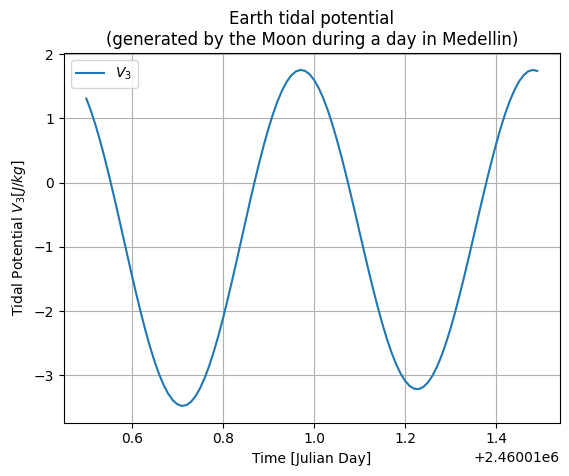

In [18]:
plt.plot(ts, Tides, label='$V_3$')
plt.xlabel('Time [Julian Day]')
plt.ylabel('Tidal Potential $V_3 [J/kg]$')
plt.title('Earth tidal potential\n(generated by the Moon during a day in Medellin)')
plt.legend()
plt.grid()

As for the tide raised by the Moon on the Earth the amplitude of the equilibrium tide ζ = 0.36 m, while for the solar tide ζ = 0.16 m. We could look at that difference between amplitudes by plotting the potential caused by the sun and by the moon in a hole day:

In [19]:
#Make it for the Sun and compare

#Matrix with len(time) rows and 4 columns for the phiP, thetaP, phiS, thetaS
Coords_S = np.zeros((len(time), 4)) 

for i in range(len(time)):
    #Cicle to transform the coordinates at every given time
    Coords_S[i] = Coordinate_transf(P_, S_, time[i][0].value)

Phis_S = np.zeros(len(time))
for i in range(len(time)):
    Phis_S[i] = cosPsi(Coords_S[i])

Tides_Sun = np.zeros(len(time))
for i in range(len(time)):
    Tides_Sun[i] = Tide(Phis_S[i], m_sun, m_earth, R_earth, au )

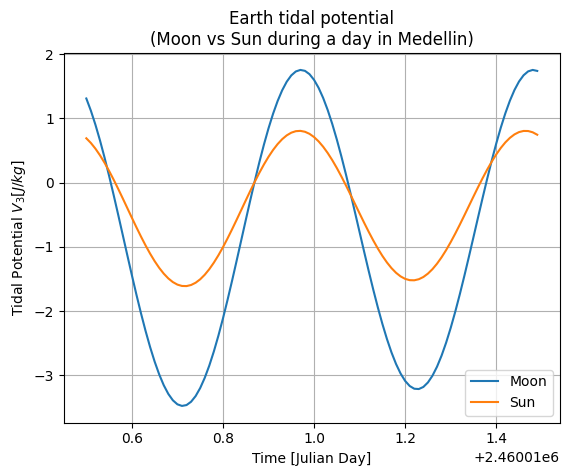

In [20]:
plt.plot(ts, Tides, label = 'Moon')
plt.plot(ts, Tides_Sun, label = 'Sun')
plt.xlabel('Time [Julian Day]')
plt.ylabel('Tidal Potential $V_3 [J/kg]$')
plt.title('Earth tidal potential\n(Moon vs Sun during a day in Medellin)')
plt.legend()
plt.grid()

Then, we confirm that the amplitude of the equilibrium tide for the Sun is smaller than the Moon's in Earth surface. 

Now, we could calculate the Earth tides all around the globe at a given time. For that it is necessary to combine the longitude and latitude coordinates:

In [21]:
# Define the longitude and latitude ranges
step = 10
lon_range = np.arange(-180, 180 + step, step)
lat_range = np.arange(-90, 90 + step, step)

# Create a matrix of longitude coordinates repeated for all latitudes
lon_matrix = np.tile(lon_range, (len(lat_range), 1))
print(lon_matrix.shape)


(19, 37)


In [22]:
#Ps = np.zeros((len(lon_range)*len(lat_range), 2))
n, m = lon_matrix.shape

# Initialize an empty array to store the resulting columns
Ps = np.zeros((n*m, 3))

# Use a nested for loop to fill the resulting_columns array
for i in range(m):
    for j in range(n):
        Ps[i*n+j][0] = lon_matrix[j][i]
        Ps[i*n+j][1] = lat_range[j]


Having the coordinates in a single matrix, let's look at the potential around the Earth caused by the Moon at a given time:

In [23]:
#Worldwide coordinates and moon's

M = ['Moon', 301]

#Earth and Moon Coordinates 
E_M_Coordinates = np.zeros((n*m, 4))

for i in range(n*m):
    E_M_Coordinates[i] = Coordinate_transf(Ps[i], M_, "2023-03-07 19:00:00")


In [24]:
Phis = np.zeros(n*m)
for i in range(n*m):
    Phis[i] = cosPsi(E_M_Coordinates[i])
    
Tides = np.zeros(n*m)
for i in range(n*m):
    Tides[i] = Tide(Phis[i], m_moon, m_earth, R_earth, a_em )

In [25]:
data = {
    'latitude': Ps[:,1],
    'longitude': Ps[:,0],
    'potential': Tides
}
df = pd.DataFrame(data)

In [26]:
#Convert the pandas DataFrame into a GeoDataFrame using geopandas.GeoDataFrame() method, and specify the geometry column as a Point object:
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))



/var/folders/0s/_xxgbjs554192y_2w2mspv3c0000gn/T/ipykernel_13759/1509341362.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


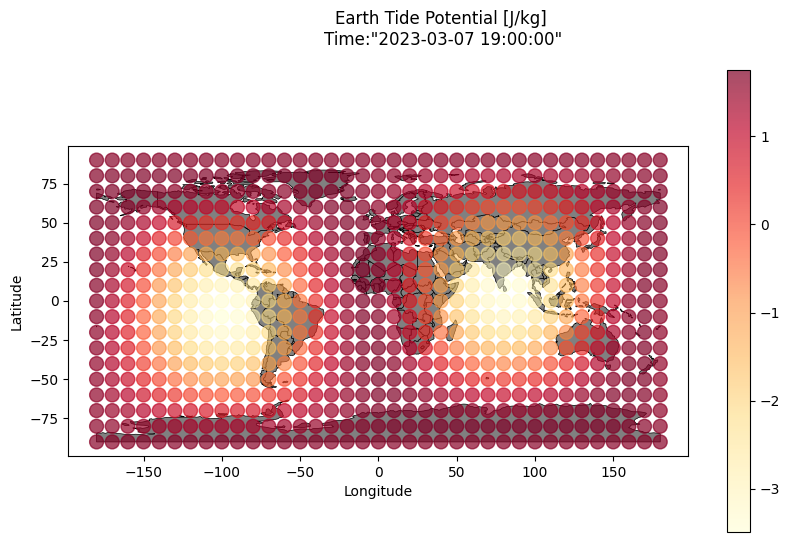

In [27]:
#Load a world map shapefile
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Create a color map:
cmap = plt.cm.get_cmap('YlOrRd')
#Transparency
cmap._init()
cmap._lut[:, -1] = np.linspace(0.5, 0.7, cmap.N+3)

fig, ax = plt.subplots(figsize=(10, 6))
world_map.plot(linewidth=0.5, edgecolor='black', color='grey', ax=ax)

#Plot the coordinates using geopandas.plot() method, and set the column parameter to the potential column, and the cmap parameter to the color map:
gdf.plot(column='potential', cmap=cmap, markersize=100, ax=ax, legend=True)
fig.suptitle('Earth Tide Potential [J/kg] \nTime:"2023-03-07 19:00:00"')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


### What is all that for?

Earth tides (altough not so famous as ocean tides) are crucial in many studies:

$\star$ Seismologists have determined that microseismic events are correlated to tidal variations in Central Asia (north of the Himalayas).

$\star$ Volcanologists use the regular, predictable Earth tide movements to calibrate and test sensitive volcano deformation monitoring instruments; tides may also trigger volcanic events.

$\star$ The semidiurnal amplitude of terrestrial tides can reach about 55 cm at the equator which is important in geodesy using Global Positioning System, very-long-baseline interferometry, and satellite laser ranging measurements.

$\star$ Also, to make precise astronomical angular measurements requires accurate knowledge of the Earth's rate of rotation (length of day, precession, in addition to nutation), which is influenced by Earth tides.

$\star$ Terrestrial tides also need to be taken in account in the case of some particle physics experiments. For instance, at the CERN or the SLAC National Accelerator Laboratory, the very large particle accelerators were designed while taking terrestrial tides into account for proper operation. 

### 4.2 Potential Theory 

Zonal Harmonics are used in this section as crucial components of the internal and external potential at a point P, now we have to consider the external and internal potential at this point taking into account the potential produced by the bulge created in the deformed body. 

<img src="Figures&plots/img_2.png" width='500'/>

Zonal harmonics are key in this deduction because they are spherical harmonics of the form $P_l(cos\theta)$, i.e., one which reduces to a Legendre polynomial. It means that we only have dependence on the colatitude $\theta$ because of the axial symmetry of our potential problem. 

Zonal harmonics can be seen as dividing the sphere in zones (as yo can see in the figure bellow), that's why they have that name.
<img src="Figures&plots/m0curves.webp" width='500'/>

Figure from: Physics Forum Insides https://www.physicsforums.com/insights/

In our case we're interested in the second zonal harmonic. One could make a better representation of this spherical harmonic using 3D matplotlib:

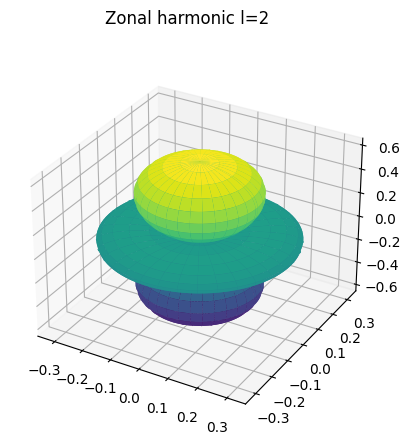

In [28]:
# Degree of the zonal harmonic
l = 2

# Create a mesh grid of theta and phi values
theta, phi = np.mgrid[0:np.pi:101j, 0:2*np.pi:101j]

Y = sph_harm(0, l, phi, theta).real

# Coordinates conversion
x = Y * np.sin(theta) * np.cos(phi)
y = Y * np.sin(theta) * np.sin(phi)
z = Y * np.cos(theta)

# Create a 3D plot of the zonal spherical harmonics 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')
fig.suptitle('Zonal harmonic l=2')
plt.show()


### 4.3 Tidal deformation

*IDEAS:* 
$\rightarrow$ Derive the proof of Chree (1896a): the yielding of the core under the force resulting from the core deforming potential is the same as that which would be produced by an outward normal force per unit area of amount ρZ A2P2(cosψ) acting at the mean core boundary, r = A.

$\rightarrow$ show that the radial displacement of the solid core produced by this deforming pressure is $\Delta R(\Psi)...$ (Love (1944)).

$\rightarrow$ Study F (measure of the effect of the ocean on the amplitude of the core tide), and H (measure of the effect of the internal structure on the external shape of the planet) in different planets with their satellites. Look at the difference when the case is for a satellite with spin rate equal to or synchronous with its orbital mean motion (hydrostatic value of H).

$\rightarrow$ Compare the amplitude of ocean tide in different cases (for the uniform ocean model) σ = ρ, with the equilibrium tide and the amplitude of the solid body tide for a planet with and without ocean.

$\rightarrow$ Calculate the height of the surface above the ocean floor for a real ocean basin and look at the variability with the general assumption for the whole earth (importance of currents on determining the shape of Earth's oceans).


### 4.5 Rotational Deformation
*IDEAS:* 
$\rightarrow$ Construct the oblate spheroid (shape of the distorted planet) using Legendre polynomial of degree 2 where the angle ψ is measured from the axis of symmetry.

$\rightarrow$ Compare the flatness of some planets calculated by the difference between radius and by the realtion with the rotational velocity. (without considering the rotational distortion).

$\rightarrow$ Look at the upper limit on the rotational velocity of the solar system planets and their corresponding rotation period (animation with the spheres and different velocities?).



### 4.6 The Darwin-Radau Relation

$\rightarrow$ Moment of inertia factor (C-) graphic for different planetary systems (if possible). Look at the Darwin–Radau model, and other general core–mantle models.

### 4.7 Shapes and Internal Structures of Satellites

$\rightarrow$ Interactive equipotential surfaces arising from rotational deformation and from tidal deformation.

$\rightarrow$ Which studies have been done in the determination of internal structures using the shape technique described in the text (example of Mimas and Jovian system)? Is it really convenient or other thechniques are being applied nowadays to determine better the shape of planets and satellites?

### 4.8 The Roche Zone 

### 4.9 Tidal Torques

### 4.10 Satellite Tides